In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('dataset_devcamp.csv')
df.describe()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,133980.000000,133980.000000,133980.000000,133980.000000,133980.000000,133980.000000,133980.000000,133980.000000
mean,94818.230079,9199.422511,254761.132468,205.977719,218.694914,0.094096,0.132893,51.770645
std,54769.102250,615.591692,85547.340828,103.369888,110.710208,0.291964,0.339460,60.623927
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,47417.750000,8562.000000,217217.000000,129.675000,133.237500,0.000000,0.000000,20.000000
50%,94815.500000,9371.000000,222087.000000,197.362500,205.912500,0.000000,0.000000,35.000000
75%,142246.250000,9731.000000,245338.000000,232.987500,234.412500,0.000000,0.000000,62.000000
max,189717.000000,9984.000000,679023.000000,533.662500,533.662500,1.000000,1.000000,2876.000000


In [4]:
anomalies = df[df['total_price'] > df['base_price']]
print(anomalies[['week', 'store_id', 'sku_id', 'total_price', 'base_price']].sample(50))

              week  store_id  sku_id  total_price  base_price
44175   2011-10-10      9498  216418      86.9250     86.2125
111529  2012-11-20      8400  216419     105.4500    104.7375
116685  2012-12-25      9611  216419     109.0125    108.3000
106940  2012-10-23      8562  216419     106.1625    105.4500
81328   2012-05-22      9745  216419     106.8750    105.4500
69005   2012-03-06      8058  216419     106.1625    105.4500
65905   2012-02-20      9613  216418     106.1625    104.0250
36728   2011-08-22      9221  216418      88.3500     84.7875
116829  2012-12-25      9432  216233     116.1375    113.2875
121103  2013-01-15      9279  216418      87.6375     86.2125
82874   2012-05-29      9250  217390     139.6500    136.8000
85954   2012-06-19      9745  300021     106.8750    106.1625
6648    2011-02-21      9250  216419     106.1625     99.0375
35304   2011-08-15      8555  216419      69.1125     68.4000
86515   2012-06-19      9043  217390     137.5125    136.8000
104632  

In [5]:
import pandas as pd

def analyze_store_impact(df):
    """
    Analyzes how store_id affects units_sold across all SKUs.
    Returns a summary DataFrame showing sales variation between stores for each SKU.
    """
    # Group by SKU and store, calculate mean sales
    sku_store_stats = df.groupby(['sku_id', 'store_id'])['units_sold'].agg(['mean', 'count']).reset_index()
    
    # Calculate variation metrics for each SKU
    results = []
    for sku, sku_group in sku_store_stats.groupby('sku_id'):
        if len(sku_group) > 1:  # Only analyze SKUs sold in multiple stores
            max_sales = sku_group['mean'].max()
            min_sales = sku_group['mean'].min()
            mean_sales = sku_group['mean'].mean()
            sales_range = max_sales - min_sales
            sales_ratio = max_sales / min_sales if min_sales > 0 else float('inf')
            
            results.append({
                'sku_id': sku,
                'stores_count': len(sku_group),
                'avg_sales': mean_sales,
                'max_sales': max_sales,
                'min_sales': min_sales,
                'sales_range': sales_range,
                'sales_ratio': sales_ratio,
                'cv': sku_group['mean'].std() / mean_sales if mean_sales > 0 else 0  # Coefficient of variation
            })
    
    return pd.DataFrame(results)

# Run analysis
store_impact_results = analyze_store_impact(df)

# Display summary
print("\nOverall statistics of store impact across all SKUs:")
print(store_impact_results.describe())

# Show SKUs with highest variation between stores
print("\nTop 10 SKUs with most store-dependent sales:")
print(store_impact_results.sort_values('sales_ratio', ascending=False).head(10))

# Show SKUs with most consistent sales across stores
print("\nTop 10 SKUs with least store-dependent sales:")
print(store_impact_results.sort_values('sales_ratio').head(10))


Overall statistics of store impact across all SKUs:
              sku_id  stores_count  avg_sales   max_sales  min_sales  \
count      27.000000     27.000000  27.000000   27.000000  27.000000   
mean   319687.740741     42.740741  40.510565  101.414112  13.063538   
std    151951.737405     26.725949  23.256779   74.643318   4.843840   
min    216233.000000      2.000000  16.891762   24.258621   7.818966   
25%    218393.000000     19.000000  22.163959   43.038793   9.663793   
50%    223245.000000     43.000000  29.973937   61.810345  11.301724   
75%    353213.000000     68.500000  54.785638  142.379310  15.409483   
max    679023.000000     75.000000  99.688506  246.663793  26.025862   

       sales_range  sales_ratio         cv  
count    27.000000    27.000000  27.000000  
mean     88.350575     8.084372   0.452944  
std      72.855021     6.329667   0.121401  
min       7.551724     1.452012   0.231384  
25%      29.146552     3.586250   0.390619  
50%      53.991379     7.268

C:\Users\bking\AppData\Local\Temp\ipykernel_16856\4081700241.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


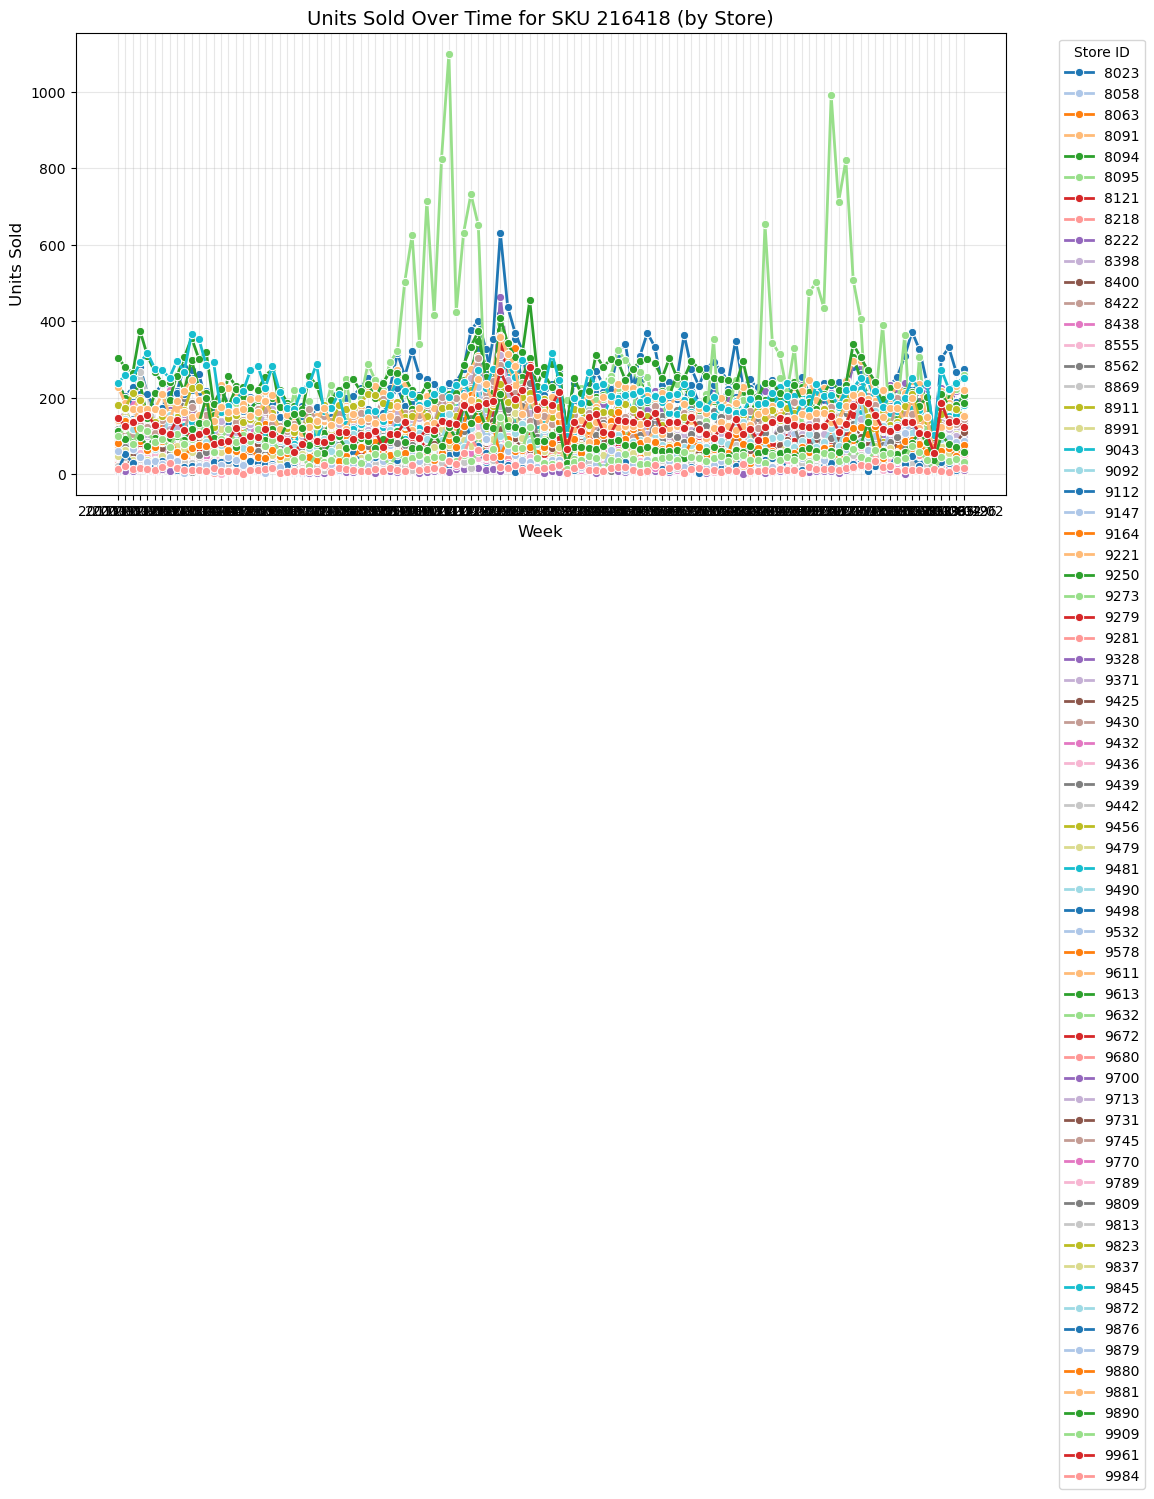

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filter data for your target SKU (e.g., SKU 216418)
target_sku = 216418
sku_data = df[df['sku_id'] == target_sku]

# 2. Plot time-series for each store
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=sku_data,
    x='week', 
    y='units_sold', 
    hue='store_id',
    palette='tab20',  # Uses distinct colors
    marker='o',       # Adds dots to data points
    linewidth=2
)

# 3. Customize the plot
plt.title(f"Units Sold Over Time for SKU {target_sku} (by Store)", fontsize=14)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Units Sold", fontsize=12)
plt.legend(title='Store ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside plot
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

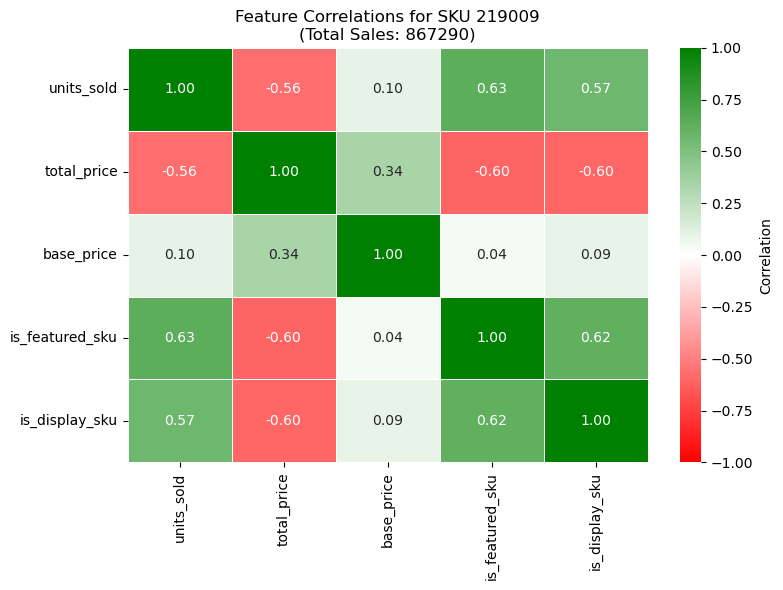

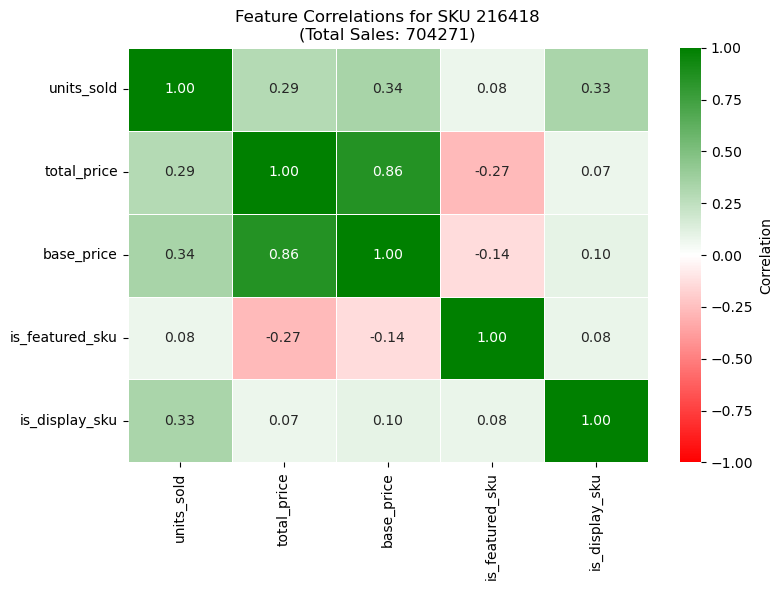

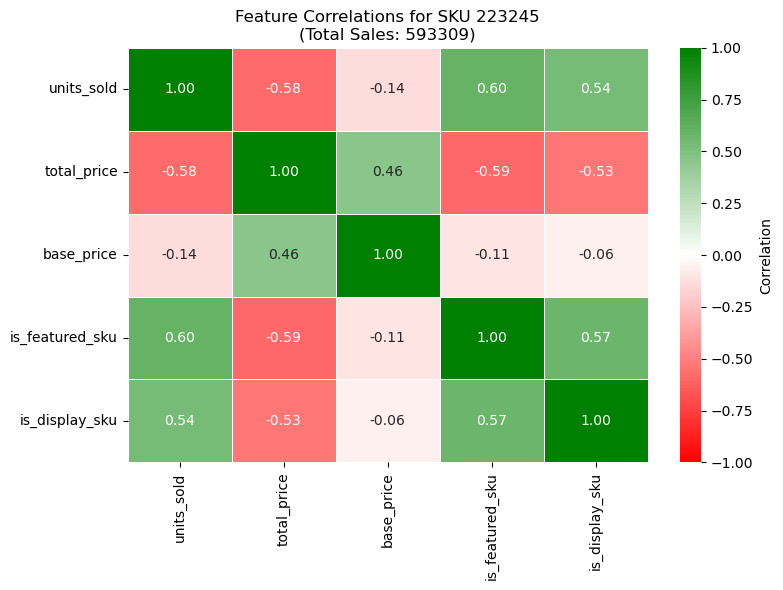

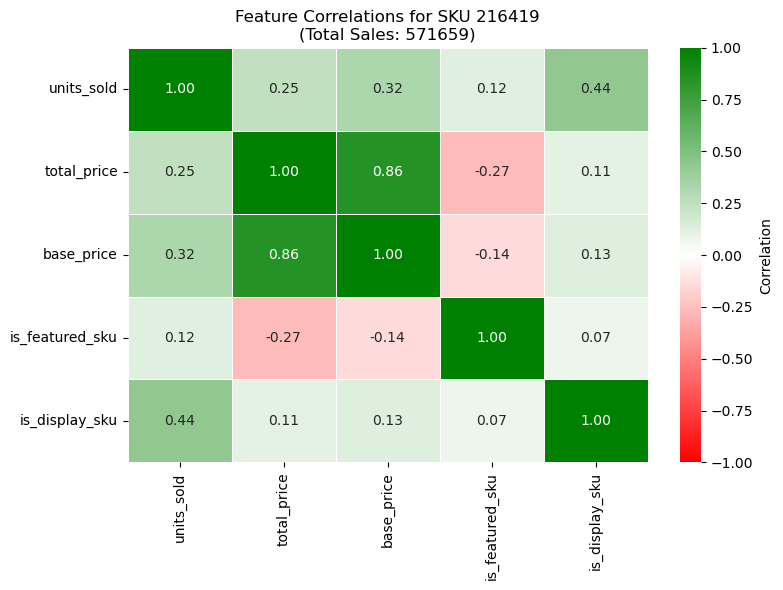

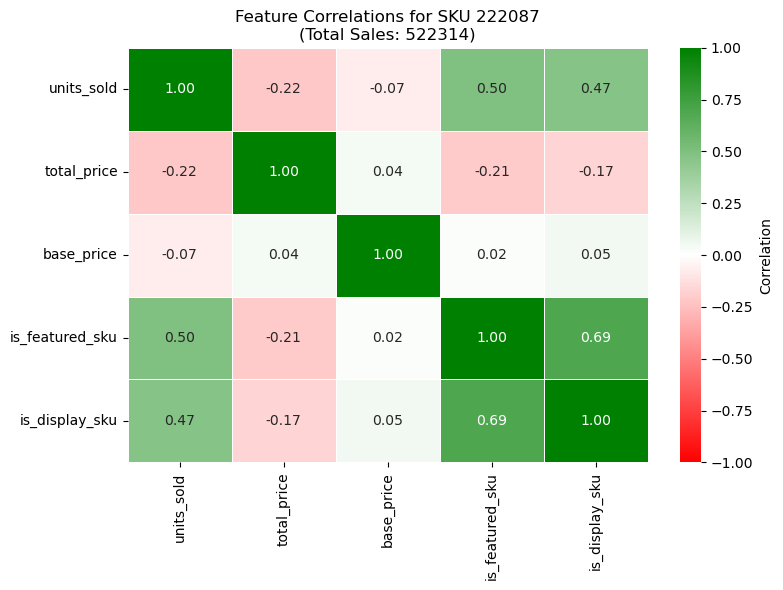

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap: red (-1) -> white (0) -> green (+1)
cmap = LinearSegmentedColormap.from_list('rg', ["red", "white", "green"], N=256)

def plot_sku_correlation_heatmaps(df, top_n_skus=5):
    """
    Plots correlation heatmaps for the top N most sold SKUs.
    Adjust top_n_skus to show more/fewer products.
    """
    # Get top SKUs by total sales volume
    top_skus = df.groupby('sku_id')['units_sold'].sum().nlargest(top_n_skus).index
    
    for sku in top_skus:
        sku_data = df[df['sku_id'] == sku]
        
        # Select relevant numerical features
        features = ['units_sold', 'total_price', 'base_price', 
                   'is_featured_sku', 'is_display_sku']
        
        # Calculate correlation matrix
        corr = sku_data[features].corr()
        
        # Plot heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, annot=True, cmap=cmap, vmin=-1, vmax=1, center=0,
                   fmt=".2f", linewidths=.5, cbar_kws={"label": "Correlation"})
        plt.title(f"Feature Correlations for SKU {sku}\n(Total Sales: {sku_data['units_sold'].sum()})")
        plt.tight_layout()
        plt.show()

# Run the function
plot_sku_correlation_heatmaps(df, top_n_skus=5)

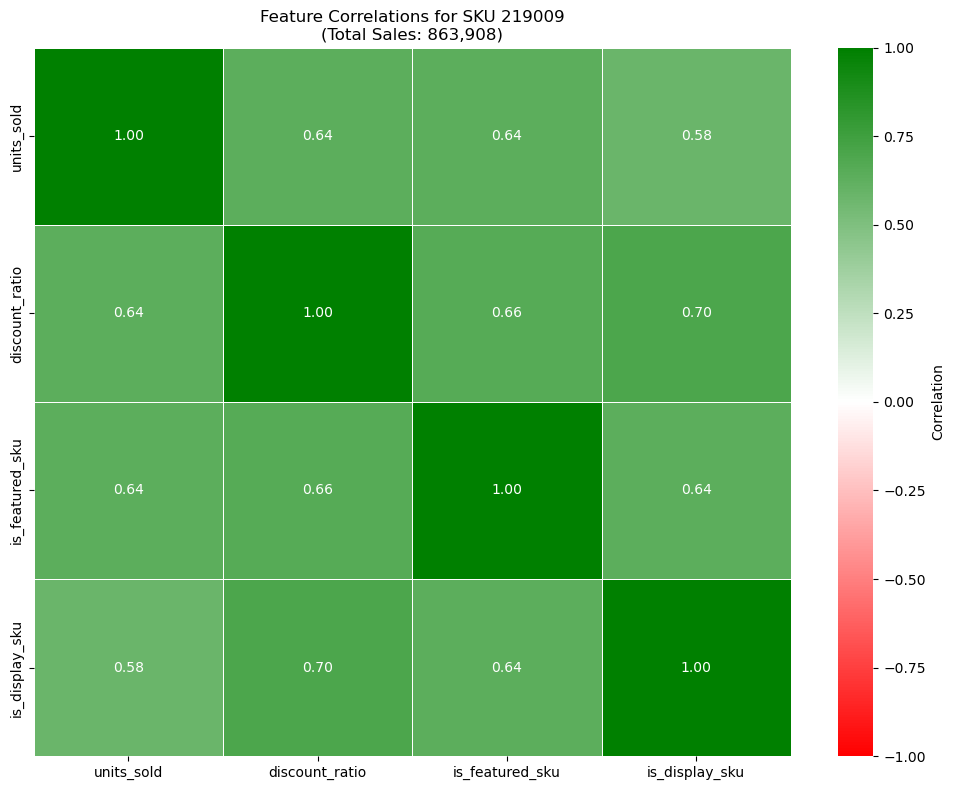

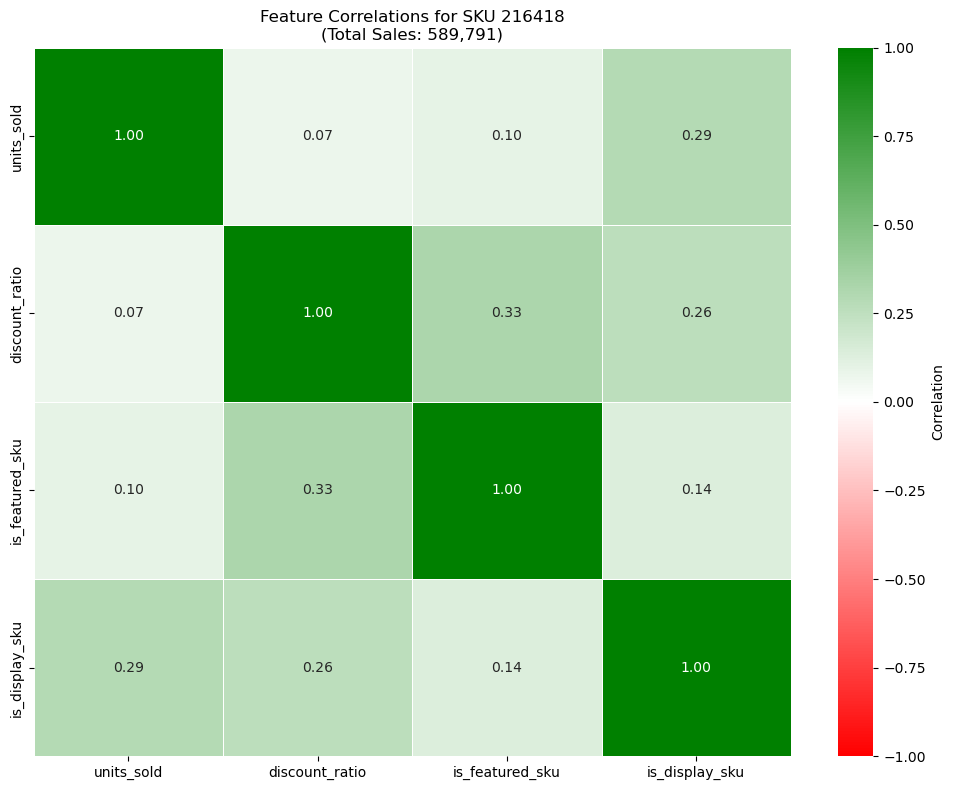

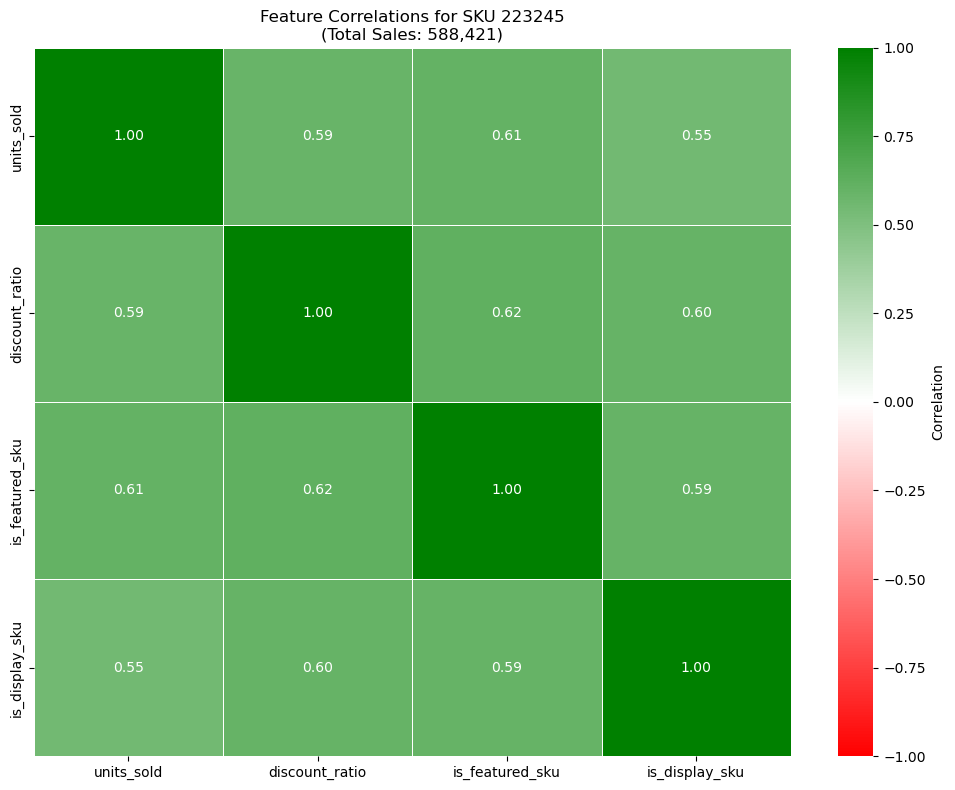

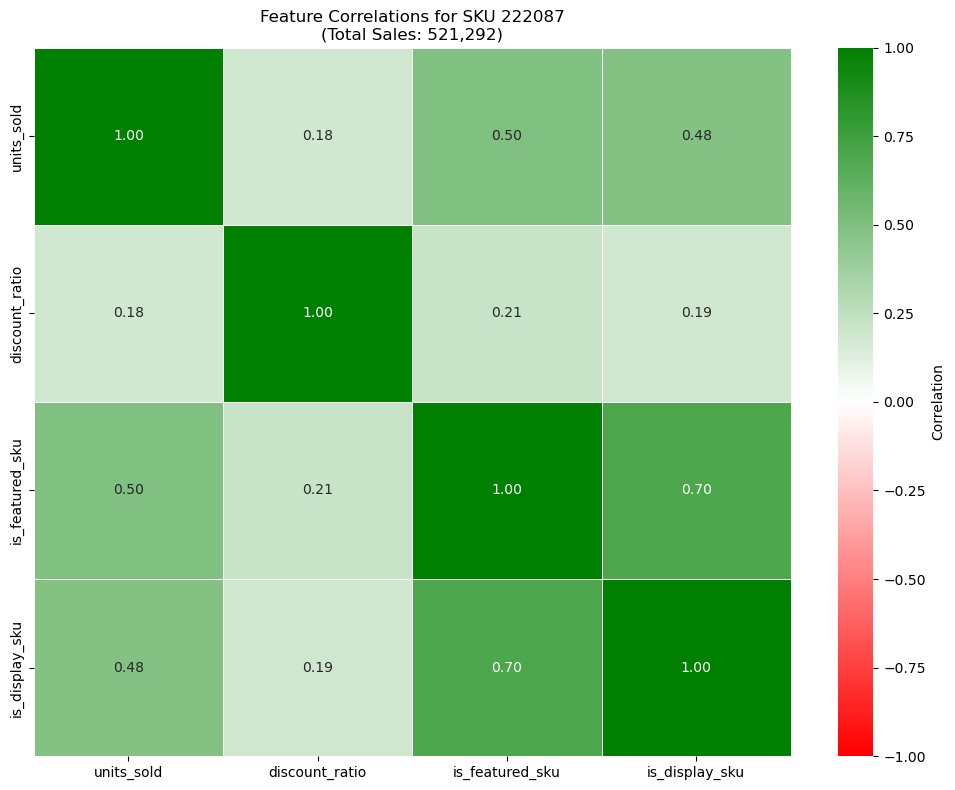

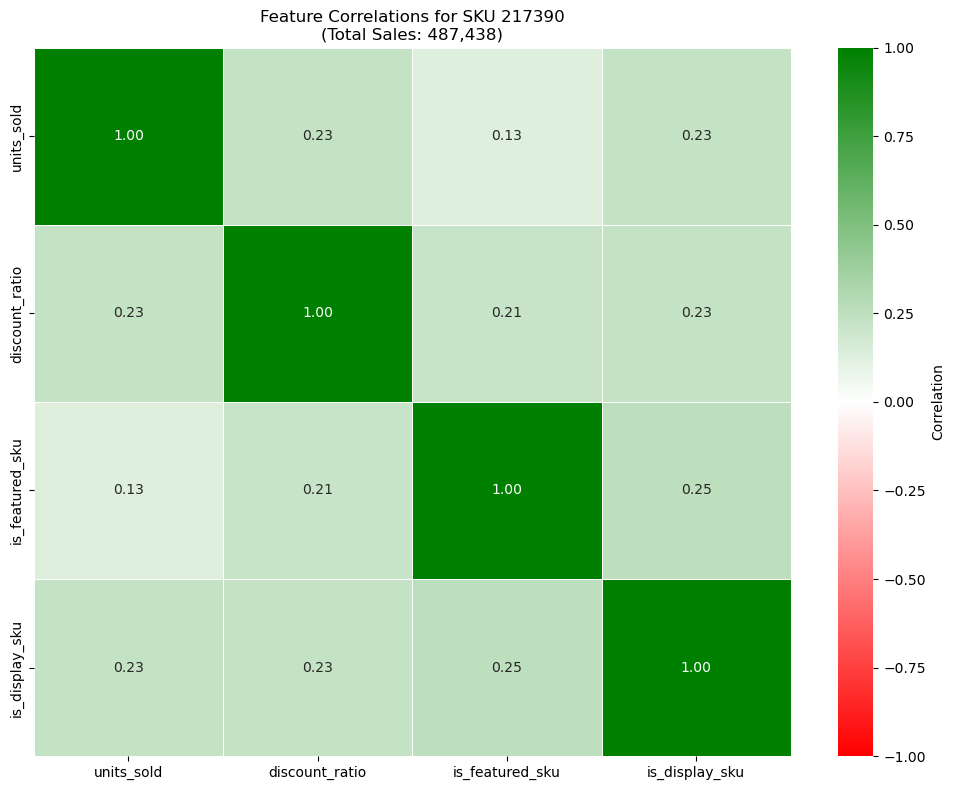

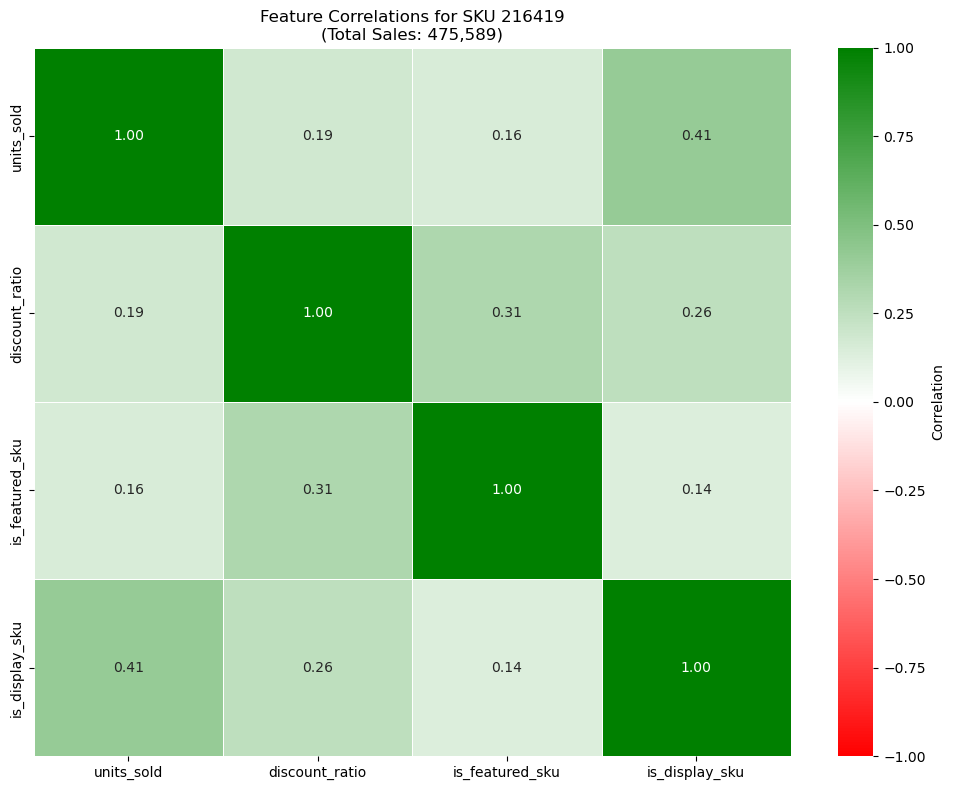

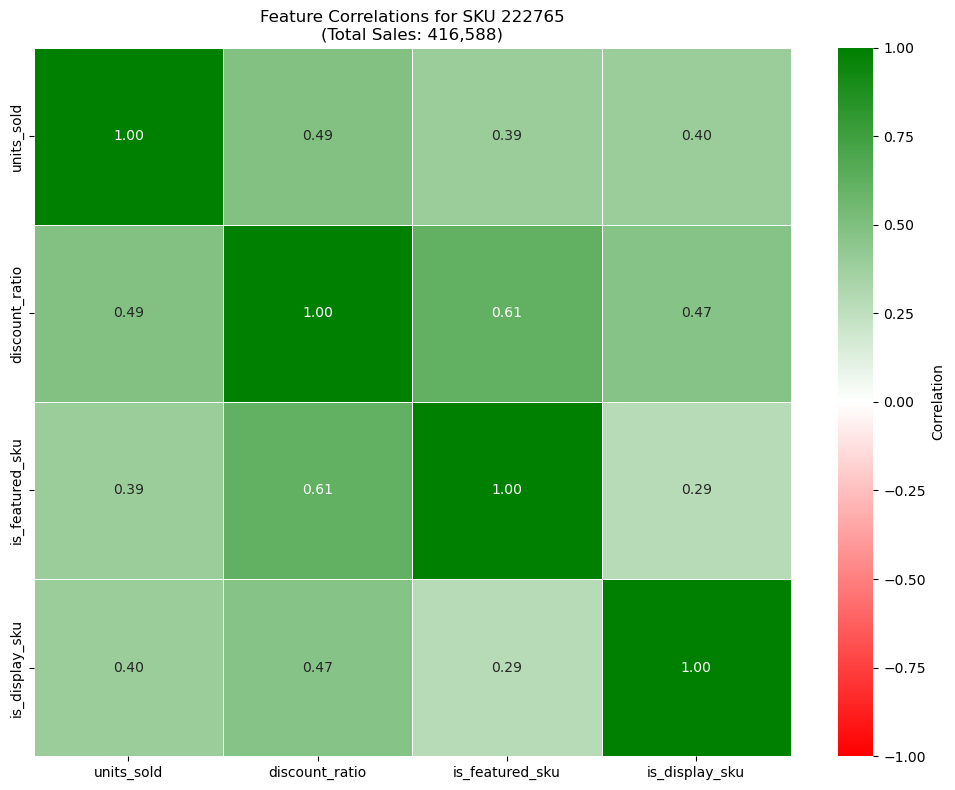

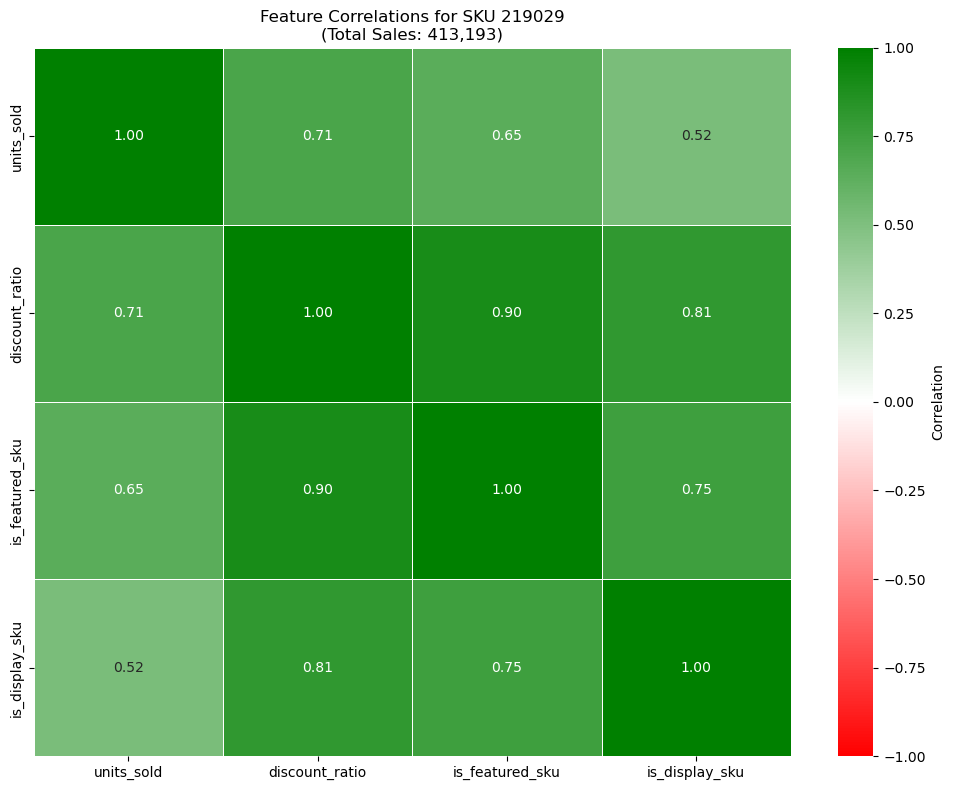

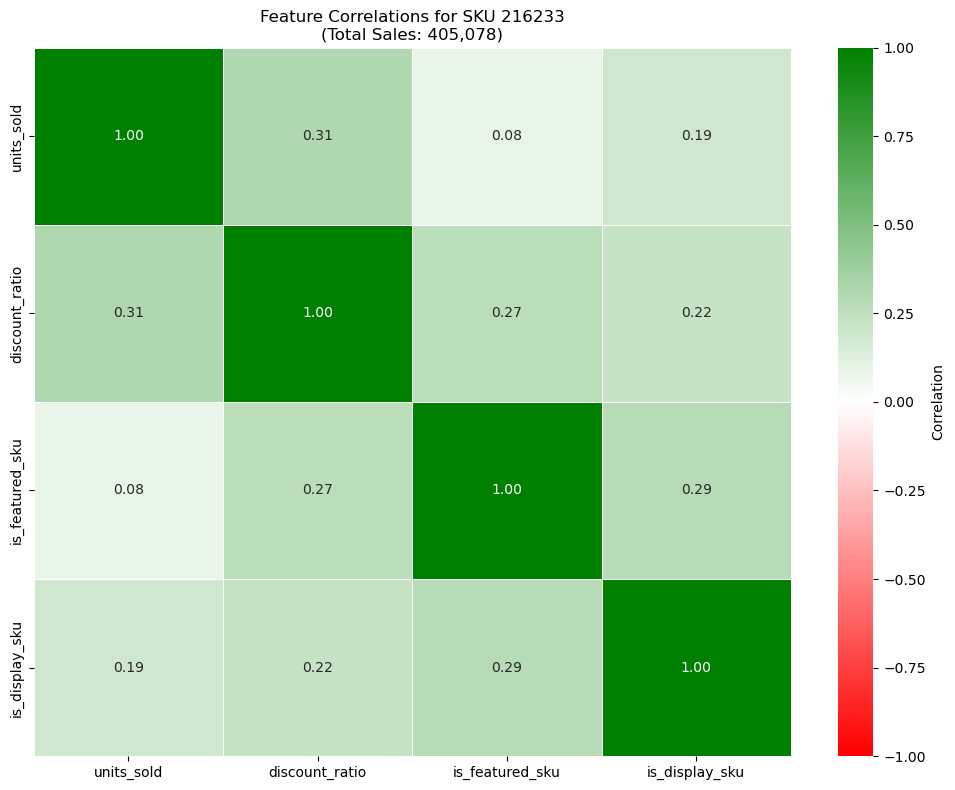

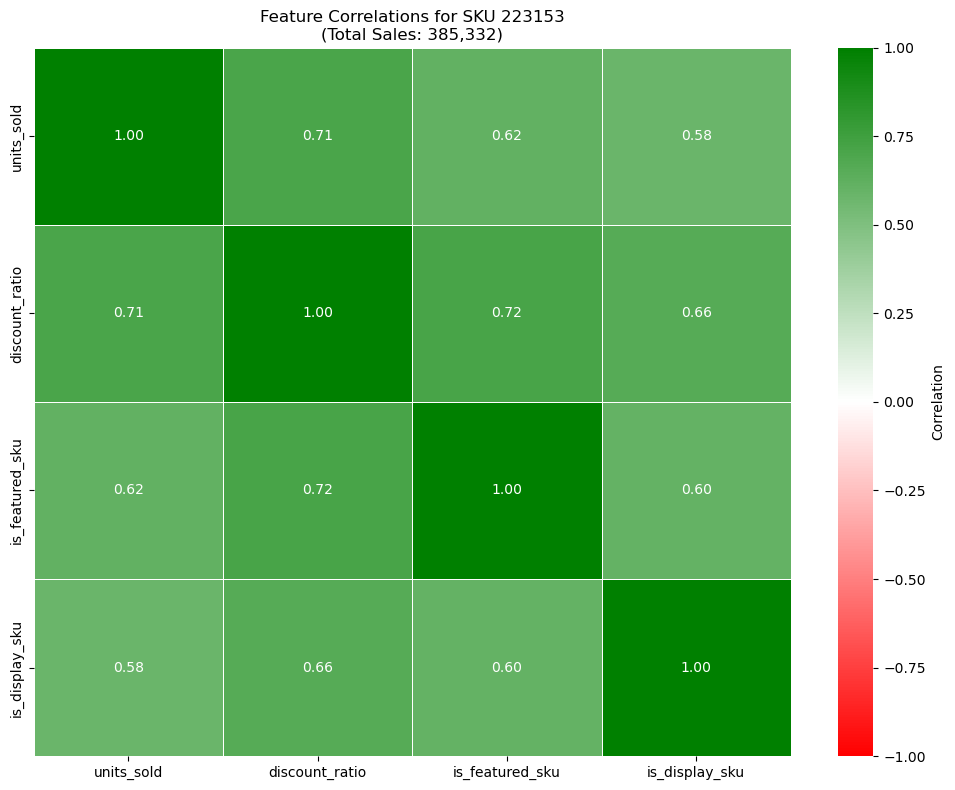

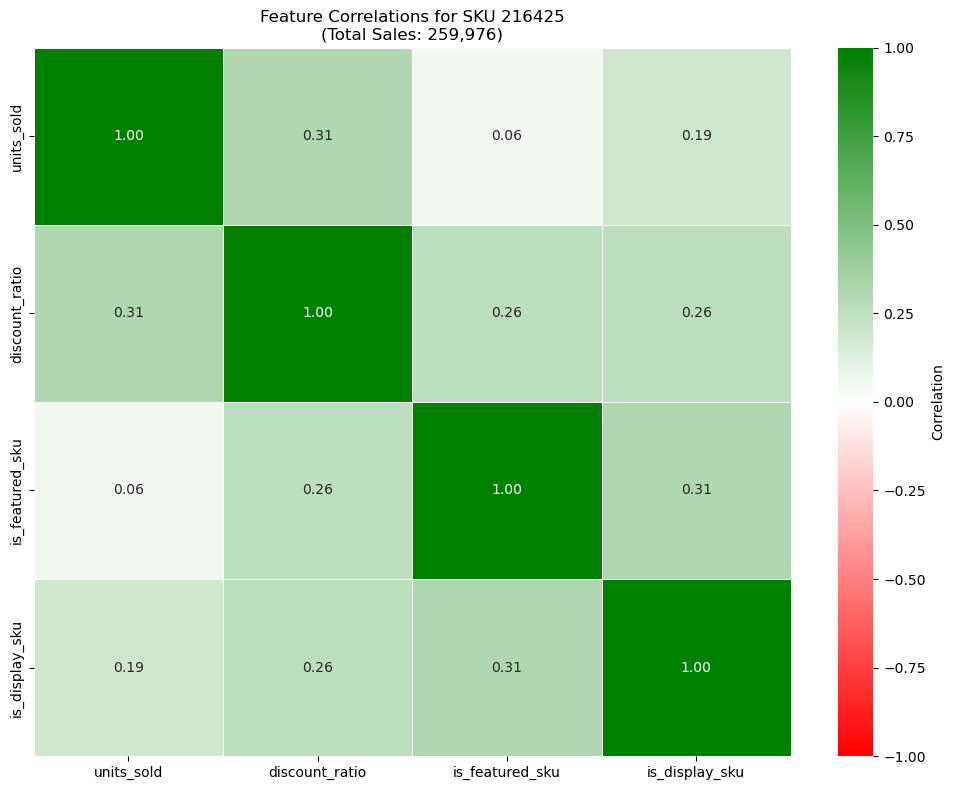

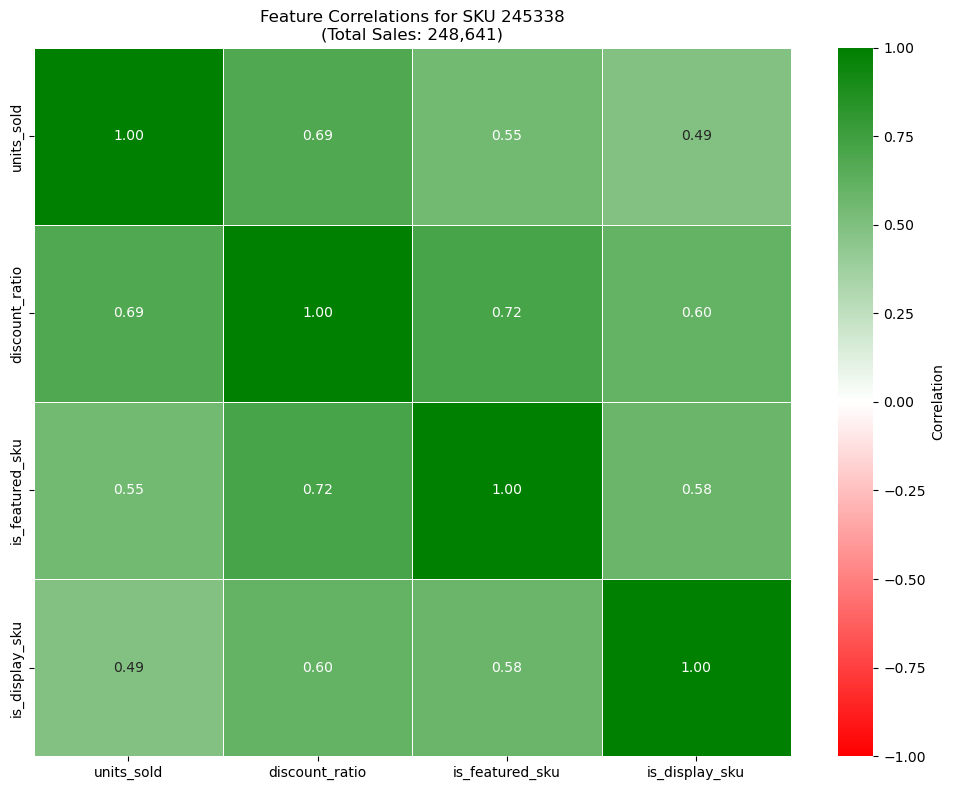

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap: red (-1) -> white (0) -> green (+1)
cmap = LinearSegmentedColormap.from_list('rg', ["red", "white", "green"], N=256)

def plot_sku_correlation_heatmaps(df, top_n_skus=10):
    """
    Plots correlation heatmaps for the top N most sold SKUs.
    Adjust top_n_skus to show more/fewer products.
    """
    # 1. Add discount ratio feature
    df['discount_ratio'] = (df['base_price'] - df['total_price']) / df['base_price']
    
    # 2. Remove rows where total_price > base_price
    df = df[df['total_price'] <= df['base_price']].copy()
    
    # 3. Add time features
    df['week'] = pd.to_datetime(df['week'])
    df['week_num'] = df['week'].dt.isocalendar().week
    df['month'] = df['week'].dt.month
    df['quarter'] = df['week'].dt.quarter
    
    # Get top SKUs by total sales volume
    top_skus = df.groupby('sku_id')['units_sold'].sum().nlargest(top_n_skus).index
    
    for sku in top_skus:
        sku_data = df[df['sku_id'] == sku]
        
        # Select relevant numerical features (now including time and discount)
        features = ['units_sold', 'discount_ratio',
                   'is_featured_sku', 'is_display_sku']
        
        # Calculate correlation matrix
        corr = sku_data[features].corr()
        
        # Plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap=cmap, vmin=-1, vmax=1, center=0,
                   fmt=".2f", linewidths=.5, cbar_kws={"label": "Correlation"})
        plt.title(f"Feature Correlations for SKU {sku}\n(Total Sales: {sku_data['units_sold'].sum():,.0f})")
        plt.tight_layout()
        plt.show()

# Run the function
plot_sku_correlation_heatmaps(df, top_n_skus=12)